In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re

file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print(df['binary_label'].value_counts())


binary_label
0    387
1    113
Name: count, dtype: int64


<ipython-input-2-676b1d65b4e5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
from sklearn.utils import resample

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())



Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


#Logistic Regression Using Tf-Idf Vectorizer


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform text into numerical features
X = vectorizer.fit_transform(df_balanced['cleaned_text'])
y = df_balanced['binary_label']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data into train-test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize Logistic Regression with balanced class weights
clf = LogisticRegression(class_weight='balanced', random_state=42)

# Train model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.60      0.52      0.56        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46



In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



Confusion Matrix:
[[15  8]
 [11 12]]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report_dict = classification_report(true_labels, predictions, target_names=all_labels, output_dict=True)

# Convert to a DataFrame
df_report = pd.DataFrame(report_dict).T

# Separate the metrics and support
df_metrics = df_report.drop(columns=['support'])
df_support = df_report['support']

# Plot heatmap for metrics
plt.figure(figsize=(10, 6))
sns.heatmap(df_metrics, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, cbar=False)

# Add support count as text annotations
for i, support in enumerate(df_support):
    plt.text(len(df_metrics.columns) + 0.5, i + 0.5, f"{int(support)}", ha='center', va='center')

plt.title("Classification Report BERT(Journal Data)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("classification_report_heatmap_bertjou.png")  # Save for PowerPoint
plt.show()


#Use Oversample Technique using SMOTE

In [ ]:
# Oversample minority class using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Initialize Logistic Regression with balanced class weights
clf = LogisticRegression(class_weight='balanced', random_state=42)

# Train model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

              precision    recall  f1-score   support

           0       0.58      0.65      0.61        23
           1       0.60      0.52      0.56        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46


Confusion Matrix:
[[15  8]
 [11 12]]


#Evaluation on Oversample Technique

0.5879017013232514


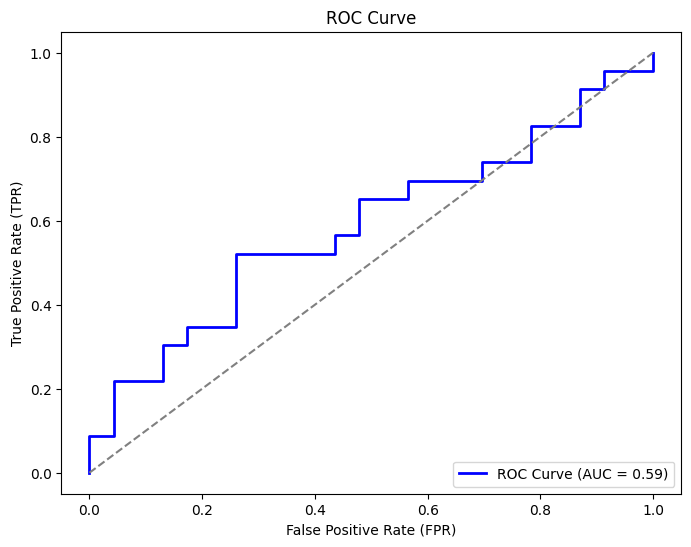

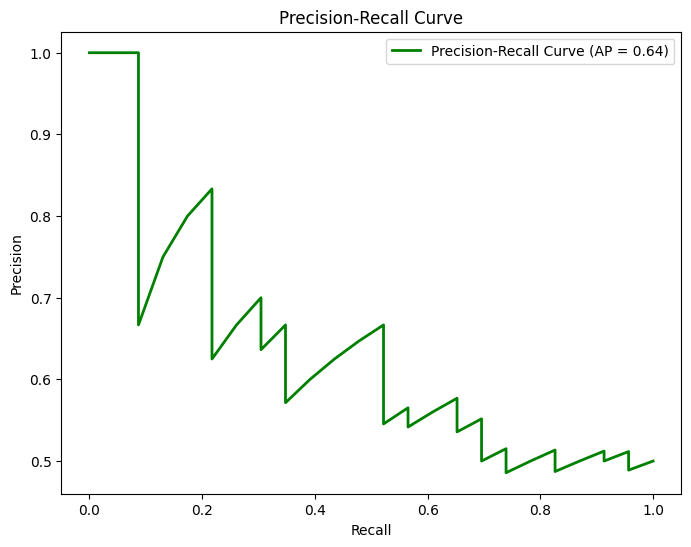

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# ROC-AUC Curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for Class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(roc_auc)
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

#Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.83      0.66        23
           1       0.64      0.30      0.41        23

    accuracy                           0.57        46
   macro avg       0.59      0.57      0.53        46
weighted avg       0.59      0.57      0.53        46


Confusion Matrix:
[[19  4]
 [16  7]]


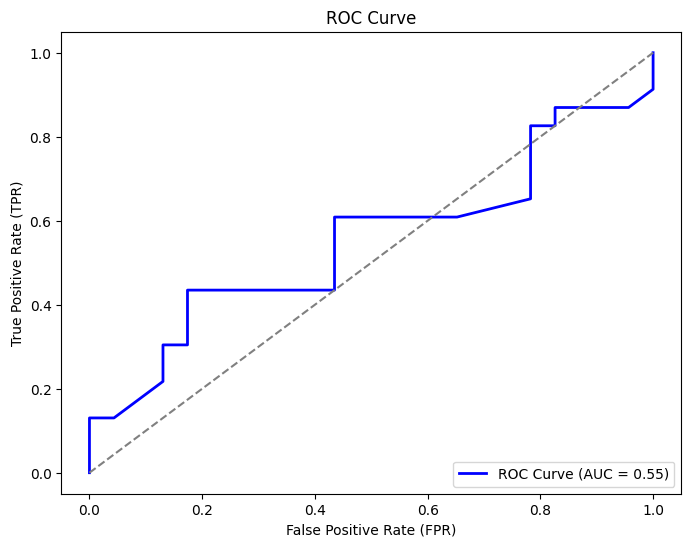

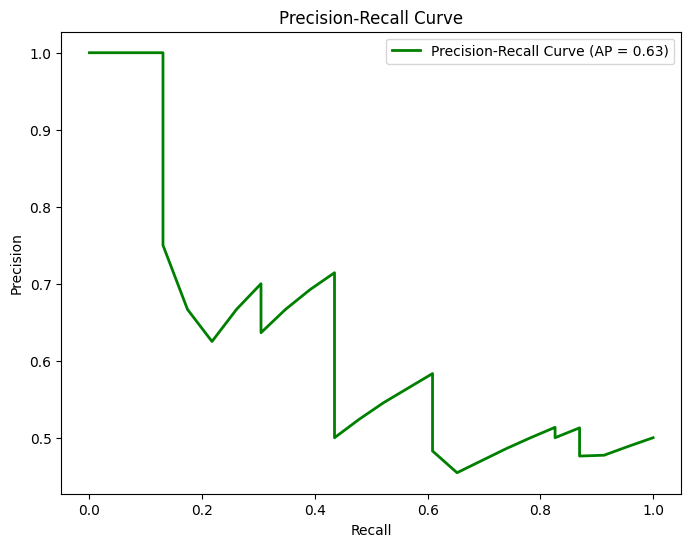

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Split data into train-test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize Random Forest with class weights
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train model
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get predicted probabilities for Class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()